In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from torch.utils.data import DataLoader, random_split
import yfinance as yf
import torch.nn.functional as F
import time
import math
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import copy

In [2]:
stock_name = "AAPL"
start = "2000-01-01"
end = "2023-01-01"
data = yf.download(stock_name, start, end) # downloading data from yahoo finance

# feature engineering
data['30_Day_MA'] = data['Close'].rolling(window=30).mean()
data['90_Day_MA'] = data['Close'].rolling(window=90).mean()
data['30_Day_STD'] = data['Close'].rolling(window=30).std()
data['90_Day_STD'] = data['Close'].rolling(window=90).std()
data['30_Upper_Band'] = data['30_Day_MA'] + (2 * data['30_Day_STD'])
data['30_Lower_Band'] = data['30_Day_MA'] - (2 * data['30_Day_STD'])
data['90_Upper_Band'] = data['90_Day_MA'] + (2 * data['90_Day_STD'])
data['90_Lower_Band'] = data['90_Day_MA'] - (2 * data['90_Day_STD'])

columns = data.columns
data_engineered = data.dropna()
scaler = MinMaxScaler(feature_range=(-1, 1))
for i in columns: # scalling data to min-max range of [-1, 1]
    data_engineered[i] = scaler.fit_transform(data_engineered[i].values.reshape(-1,1))

[*********************100%%**********************]  1 of 1 completed


C:\Users\jono_\AppData\Local\Temp\ipykernel_18400\3185198938.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_engineered[i] = scaler.fit_transform(data_engineered[i].values.reshape(-1,1))
C:\Users\jono_\AppData\Local\Temp\ipykernel_18400\3185198938.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_engineered[i] = scaler.fit_transform(data_engineered[i].values.reshape(-1,1))
C:\Users\jono_\AppData\Local\Temp\ipykernel_18400\3185198938.py:20: SettingWithCopyWarning: 
A value is trying to be s

In [34]:
def sequence_split(data, lookback, val_start_date, test_start_date): # splitting into the 5 sequences
    data_sequenced = []
    
    for i in range(len(data) - lookback):
        sequence = data[i: i + lookback]
        data_sequenced.append(sequence)
        
    data_sequenced = np.array(data_sequenced)
    
    # Find indices for validation and test sets
    val_start_idx = np.where(data.index >= val_start_date)[0][0] - lookback
    test_start_idx = np.where(data.index >= test_start_date)[0][0] - lookback

    x_train = data_sequenced[:val_start_idx, :-1, :]
    y_train = data_sequenced[:val_start_idx, -1, 3]  # index 3 for close data
    
    x_val = data_sequenced[val_start_idx:test_start_idx, :-1, :]
    y_val = data_sequenced[val_start_idx:test_start_idx, -1, 3]
    
    x_test = data_sequenced[test_start_idx:, :-1, :]
    y_test = data_sequenced[test_start_idx:, -1, 3]
    
    # Converting datasets to tensors
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
    x_val = torch.tensor(x_val, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    print(y_val.shape) # checking that val is same size across all sequence lengths
    print(y_test.shape)
    
    batch_size = 64
    # Creating TensorDatasets and DataLoaders
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader, y_val, y_test, y_train

lookback_periods = [5, 10, 20, 40, 80]  # Sequence lengths
datasets = []
true_y = []
data_ = np.array(data_engineered)

val_start_date = "2018-01-01"
test_start_date = "2021-12-31"

for lookback in lookback_periods:
    train_loader, val_loader, test_loader, y_val, y_test, y_train = sequence_split(data_engineered, lookback, val_start_date, test_start_date)
    datasets.append([train_loader, val_loader, test_loader])
    true_y.append([y_val, y_test, y_train])

torch.Size([1007, 1])
torch.Size([252, 1])
torch.Size([1007, 1])
torch.Size([252, 1])
torch.Size([1007, 1])
torch.Size([252, 1])
torch.Size([1007, 1])
torch.Size([252, 1])
torch.Size([1007, 1])
torch.Size([252, 1])


In [4]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, hidden_layers, dropout=0.25):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.hidden_layers = hidden_layers

        self.rnn = nn.RNN(input_dim, hidden_size, hidden_layers, batch_first=True, dropout=dropout)
        self.lin = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        hidden_0 = torch.zeros(self.hidden_layers, x.size(0), self.hidden_size, device=x.device).requires_grad_()
        out, _ = self.rnn(x, hidden_0.detach())
        out = self.lin(out[:, -1, :])
        return out

In [5]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, hidden_layers, dropout=0.25):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.hidden_layers = hidden_layers

        self.gru = nn.GRU(input_dim, hidden_size, hidden_layers, batch_first=True, dropout=dropout)
        self.lin = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        hidden_0 = torch.zeros(self.hidden_layers, x.size(0), self.hidden_size, device=x.device).requires_grad_()
        out, _ = self.gru(x, hidden_0.detach())
        out = self.lin(out[:, -1, :])
        return out

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, hidden_layers, dropout=0.25):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.hidden_layers = hidden_layers

        self.lstm = nn.LSTM(input_dim, hidden_size, hidden_layers, batch_first=True, dropout=dropout)
        self.lin = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        # Renamed h0 to hidden_0 and c0 to cell_0
        hidden_0 = torch.zeros(self.hidden_layers, x.size(0), self.hidden_size, device=x.device).requires_grad_()
        cell_0 = torch.zeros(self.hidden_layers, x.size(0), self.hidden_size, device=x.device).requires_grad_()
        out, _ = self.lstm(x, (hidden_0.detach(), cell_0.detach()))
        out = self.lin(out[:, -1, :])
        return out

In [7]:
def Training(parameters, data, num_epochs, model_type):
    train_loader = data[0]
    val_loader = data[1]
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # automated selection of RNN variant
    if model_type == 1:
        print('RNN Model')
        model = RNN(input_dim=parameters[0], hidden_size=parameters[1], output_dim=parameters[2], hidden_layers=parameters[3]).to(device)
    elif model_type == 2:
        print('GRU Model')
        model = GRU(input_dim=parameters[0], hidden_size=parameters[1], output_dim=parameters[2], hidden_layers=parameters[3]).to(device)
    else:
        print('LSTM Model')
        model = LSTM(input_dim=parameters[0], hidden_size=parameters[1], output_dim=parameters[2], hidden_layers=parameters[3]).to(device)
        
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, verbose=True)
    
    # Eval metrics
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    val_mae = np.zeros(num_epochs)
    val_rmse = np.zeros(num_epochs)
    
    # for retaining best model based on val losss
    best_val_loss = float('inf')
    best_model_state = copy.deepcopy(model.state_dict())
    best_stats = []
    start_time = time.time()

    for t in range(num_epochs): #training
        model.train()
        train_losses = []
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_train_pred = model(x_batch)
            loss = criterion(y_train_pred, y_batch)
            train_losses.append(loss.item())

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
        train_loss[t] = np.mean(train_losses)

        # validation
        model.eval()
        val_losses = []
        val_maes = []
        val_rmses = []
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                y_val_pred = model(x_batch)
                loss = criterion(y_val_pred, y_batch)
                val_losses.append(loss.item())
                val_maes.append((torch.abs(y_val_pred - y_batch)).mean().item())
                val_rmses.append(math.sqrt(loss))

        val_loss[t] = np.mean(val_losses)
        val_mae[t] = np.mean(val_maes)
        val_rmse[t] = np.mean(val_rmses)

        # Check if the current validation loss is the best one and save the best model state
        if val_loss[t] < best_val_loss:
            best_val_loss = val_loss[t]
            best_model_state = copy.deepcopy(model.state_dict())
            best_stats = [t, train_loss[t], val_loss[t], val_mae[t], val_rmse[t]]
            

        if t % 10 == 0:
            print(f"Epoch {t}, Train Loss: {train_loss[t]:.5f}, Val Loss: {val_loss[t]:.5f}, Val MAE: {val_mae[t]:.5f}, Val RMSE: {val_rmse[t]:.5f}")
        
        scheduler.step(val_loss[t])

        if optimiser.param_groups[0]['lr'] <= 3.1250e-04: # stopping after reduction 5 times
            print("Model training stopped")
            break

    training_time = time.time() - start_time
    print(f"Training time: {training_time:.5f} seconds")

    # reloading the best state
    model.load_state_dict(best_model_state)
    print(f"Best Model Stats: Best Epoch: {best_stats[0]}, Train Loss: {best_stats[1]:.5f}, Val Loss: {best_stats[2]:.5f}, Val MAE: {best_stats[3]:.5f}, Val RMSE: {best_stats[4]:.5f}")
    
    return model, train_loss, val_loss, val_mae, val_rmse, best_stats


In [9]:
def Testing(model, data_loaders): # same as validation essentially but keeping the prediction
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = torch.nn.MSELoss(reduction='mean')
    model.eval()

    all_predictions = []
    all_losses = []
    all_maes = []
    all_rmses = []

    for data_loader in data_loaders: # getting predictions and stats for train/val/test datasets
        predictions = []
        losses = []
        maes = []
        rmses = []
        
        with torch.no_grad():
            for x_batch, y_batch in data_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                y_pred = model(x_batch)
                predictions.extend(y_pred.cpu().numpy())

                loss = criterion(y_pred, y_batch)
                losses.append(loss.item())
                maes.append(torch.abs(y_pred - y_batch).mean().item())
                rmses.append(math.sqrt(loss.item()))

        all_predictions.append(np.array(predictions))
        all_losses.append(np.mean(losses))
        all_maes.append(np.mean(maes))
        all_rmses.append(np.mean(rmses))

    return all_predictions, all_losses, all_maes, all_rmses

In [10]:
parameters = [14, 32, 1, 1] # only using one set of parameters for the model. Will have to test more in future work.

In [11]:
RNN_models = []
for i in datasets:#ttraining RNN models
    model, train_loss, val_loss, val_mae, val_rmse, best_stats = Training(parameters, i, 300,1)
    RNN_models.append([model, train_loss, val_loss, val_mae, val_rmse, best_stats])
    print()

RNN Model


C:\Users\jono_\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0, Train Loss: 0.08922, Val Loss: 0.16781, Val MAE: 0.31767, Val RMSE: 0.32278
Epoch 10, Train Loss: 0.00114, Val Loss: 0.04940, Val MAE: 0.16341, Val RMSE: 0.16778
Epoch 20, Train Loss: 0.00030, Val Loss: 0.02165, Val MAE: 0.10421, Val RMSE: 0.10951
Epoch 30, Train Loss: 0.00013, Val Loss: 0.01360, Val MAE: 0.08060, Val RMSE: 0.08685
Epoch 40, Train Loss: 0.00010, Val Loss: 0.01171, Val MAE: 0.07421, Val RMSE: 0.08070
Epoch 50, Train Loss: 0.00009, Val Loss: 0.01130, Val MAE: 0.07274, Val RMSE: 0.07914
Epoch 60, Train Loss: 0.00008, Val Loss: 0.01119, Val MAE: 0.07228, Val RMSE: 0.07853
Epoch 70, Train Loss: 0.00008, Val Loss: 0.01111, Val MAE: 0.07193, Val RMSE: 0.07803
Epoch 80, Train Loss: 0.00007, Val Loss: 0.01101, Val MAE: 0.07152, Val RMSE: 0.07746
Epoch 90, Train Loss: 0.00007, Val Loss: 0.01089, Val MAE: 0.07101, Val RMSE: 0.07682
Epoch 100, Train Loss: 0.00007, Val Loss: 0.01074, Val MAE: 0.07042, Val RMSE: 0.07612
Epoch 110, Train Loss: 0.00006, Val Loss: 0.01057, Val

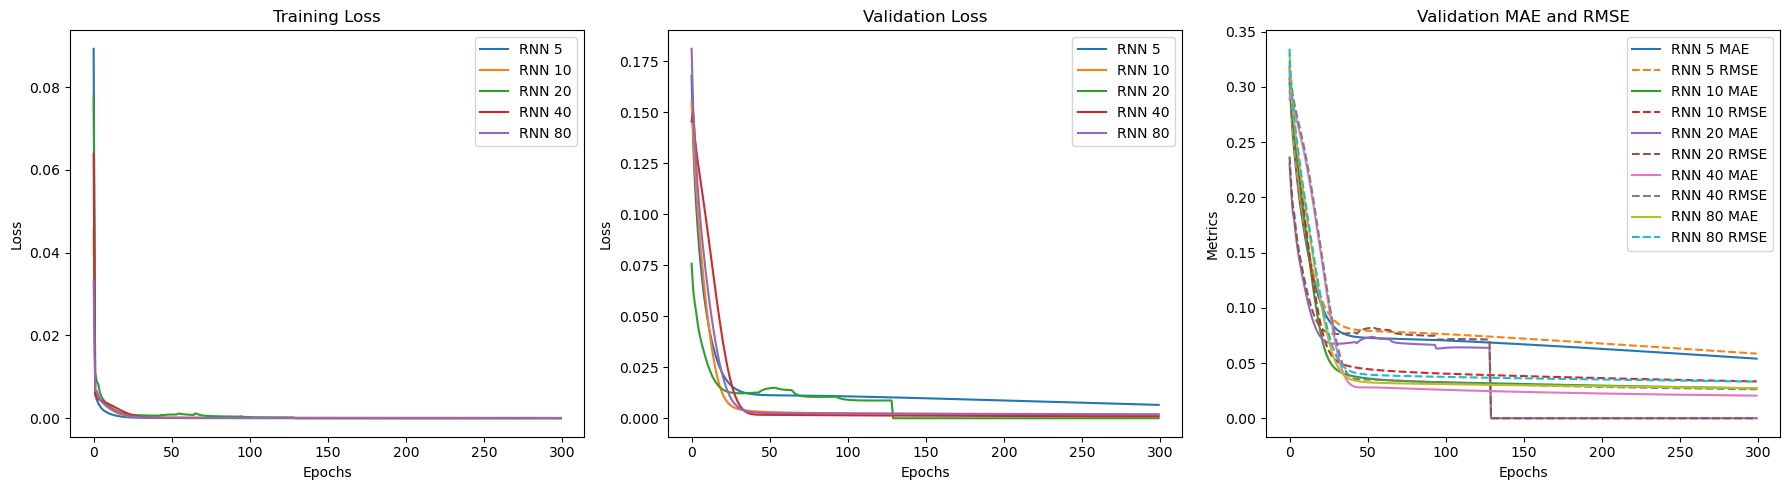

In [12]:
# Printing loss graphs
num_datasets = len(datasets)
sequences = [5,10,20,40,80]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loop through each dataset and plot
for i in range(num_datasets):
    train_loss = RNN_models[i][1]
    val_loss = RNN_models[i][2]
    val_mae = RNN_models[i][3]
    val_rmse = RNN_models[i][4]
    axes[0].plot(train_loss, label=f"RNN {sequences[i]}") # training loss

    axes[1].plot(val_loss, label=f"RNN {sequences[i]}") # val loss
    
    # MAE and RMSE
    axes[2].plot(val_mae, label=f"RNN {sequences[i]} MAE")
    axes[2].plot(val_rmse, label=f"RNN {sequences[i]} RMSE", linestyle='--')

axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

axes[2].set_title("Validation MAE and RMSE")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Metrics")
axes[2].legend()

plt.tight_layout()
plt.show()

In [13]:
RNN_model_predictions = [] # making predictions for the training, val and test data on the RNN models

for y in range(len(RNN_models)):
    all_predictions, all_losses, all_maes, all_rmses = Testing(RNN_models[y][0], datasets[y])
    RNN_model_predictions.append([all_predictions, all_losses, all_maes, all_rmses])
    
y_preds_val = []
for i in RNN_model_predictions:
    y_preds_val.append(i[0][1])

In [14]:
GRU_models = [] # making predictions for the training, val and test data on the GRU models
for i in datasets:
    model, train_loss, val_loss, val_mae, val_rmse, best_stats = Training(parameters, i, 300,2)
    GRU_models.append([model, train_loss, val_loss, val_mae, val_rmse, best_stats])
    print()

GRU Model
Epoch 0, Train Loss: 0.02865, Val Loss: 0.12582, Val MAE: 0.27027, Val RMSE: 0.27553
Epoch 10, Train Loss: 0.00170, Val Loss: 0.04695, Val MAE: 0.16488, Val RMSE: 0.16973
Epoch 20, Train Loss: 0.00045, Val Loss: 0.01060, Val MAE: 0.07607, Val RMSE: 0.08212
Epoch 30, Train Loss: 0.00014, Val Loss: 0.00291, Val MAE: 0.03706, Val RMSE: 0.04456
Epoch 40, Train Loss: 0.00009, Val Loss: 0.00216, Val MAE: 0.03086, Val RMSE: 0.03898
Epoch 50, Train Loss: 0.00008, Val Loss: 0.00207, Val MAE: 0.03028, Val RMSE: 0.03828
Epoch 60, Train Loss: 0.00007, Val Loss: 0.00203, Val MAE: 0.03008, Val RMSE: 0.03788
Epoch 70, Train Loss: 0.00007, Val Loss: 0.00199, Val MAE: 0.02986, Val RMSE: 0.03751
Epoch 80, Train Loss: 0.00006, Val Loss: 0.00195, Val MAE: 0.02963, Val RMSE: 0.03714
Epoch 90, Train Loss: 0.00006, Val Loss: 0.00192, Val MAE: 0.02936, Val RMSE: 0.03677
Epoch 100, Train Loss: 0.00006, Val Loss: 0.00188, Val MAE: 0.02908, Val RMSE: 0.03641
Epoch 110, Train Loss: 0.00006, Val Loss: 0.

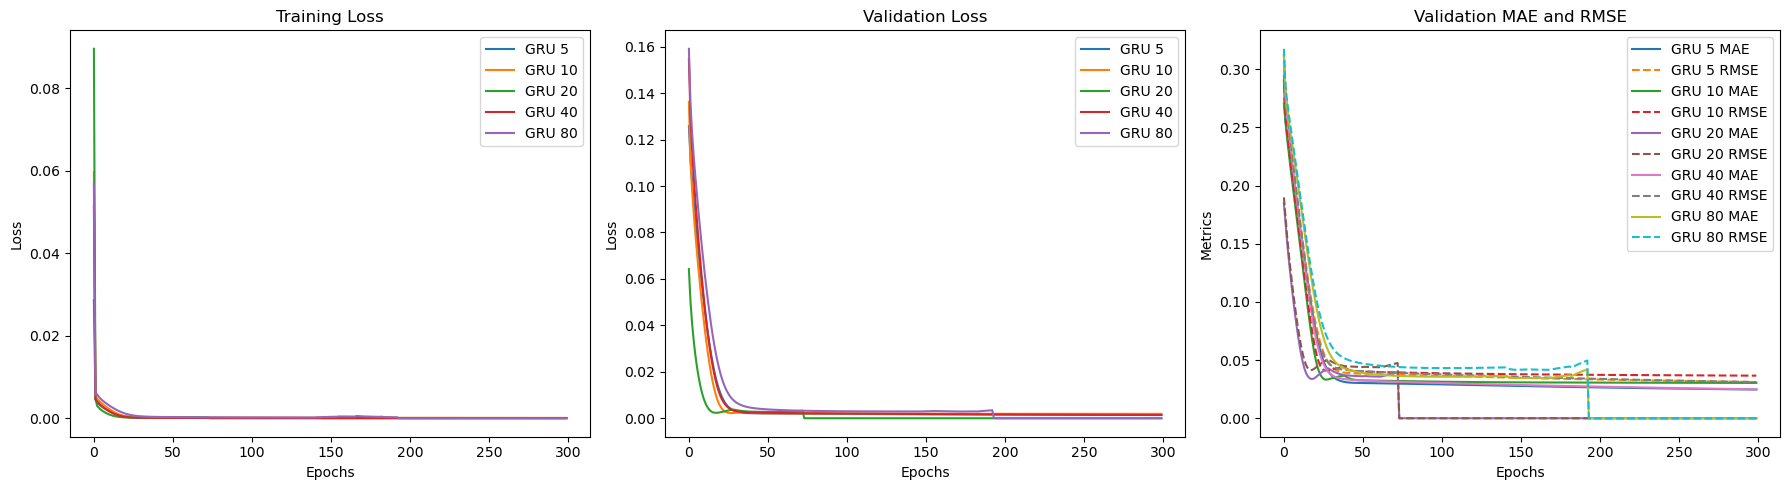

In [15]:
# printing graph for GRU same as above
num_datasets = len(datasets)
sequences = [5,10,20,40,80]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


for i in range(num_datasets):
    train_loss = GRU_models[i][1]
    val_loss = GRU_models[i][2]
    val_mae = GRU_models[i][3]
    val_rmse = GRU_models[i][4]

    axes[0].plot(train_loss, label=f"GRU {sequences[i]}")

    axes[1].plot(val_loss, label=f"GRU {sequences[i]}")
    
    axes[2].plot(val_mae, label=f"GRU {sequences[i]} MAE")
    axes[2].plot(val_rmse, label=f"GRU {sequences[i]} RMSE", linestyle='--')

axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

axes[2].set_title("Validation MAE and RMSE")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Metrics")
axes[2].legend()

plt.tight_layout()
plt.show()

In [16]:
GRU_model_predictions = []

for y in range(len(GRU_models)):
    all_predictions, all_losses, all_maes, all_rmses = Testing(GRU_models[y][0], datasets[y])
    GRU_model_predictions.append([all_predictions, all_losses, all_maes, all_rmses])
    
for i in GRU_model_predictions:
    y_preds_val.append(i[0][1])

In [17]:
LSTM_models = []
for i in datasets:
    model, train_loss, val_loss, val_mae, val_rmse, best_stats = Training(parameters, i, 300,3)
    LSTM_models.append([model, train_loss, val_loss, val_mae, val_rmse, best_stats])
    print()

LSTM Model
Epoch 0, Train Loss: 0.07455, Val Loss: 0.25822, Val MAE: 0.40674, Val RMSE: 0.41120
Epoch 10, Train Loss: 0.01061, Val Loss: 0.24572, Val MAE: 0.38640, Val RMSE: 0.39137
Epoch 00016: reducing learning rate of group 0 to 5.0000e-03.
Epoch 20, Train Loss: 0.00972, Val Loss: 0.23018, Val MAE: 0.38250, Val RMSE: 0.38692
Epoch 30, Train Loss: 0.00588, Val Loss: 0.15979, Val MAE: 0.31230, Val RMSE: 0.31718
Epoch 40, Train Loss: 0.00298, Val Loss: 0.09889, Val MAE: 0.23657, Val RMSE: 0.24161
Epoch 50, Train Loss: 0.00125, Val Loss: 0.05969, Val MAE: 0.17358, Val RMSE: 0.17887
Epoch 60, Train Loss: 0.00049, Val Loss: 0.04056, Val MAE: 0.13555, Val RMSE: 0.14132
Epoch 70, Train Loss: 0.00024, Val Loss: 0.03251, Val MAE: 0.11721, Val RMSE: 0.12370
Epoch 80, Train Loss: 0.00016, Val Loss: 0.02913, Val MAE: 0.10904, Val RMSE: 0.11603
Epoch 90, Train Loss: 0.00013, Val Loss: 0.02758, Val MAE: 0.10522, Val RMSE: 0.11244
Epoch 100, Train Loss: 0.00012, Val Loss: 0.02674, Val MAE: 0.10313,

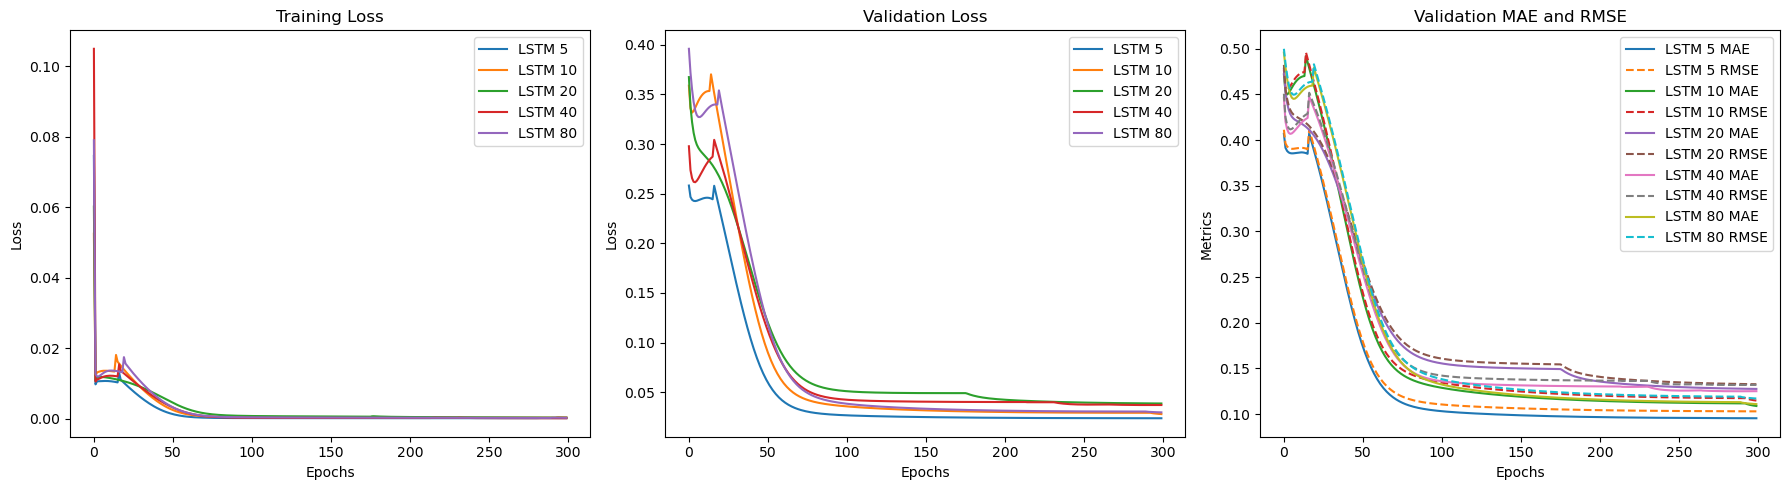

In [18]:
# Graphs for LSTM
num_datasets = len(datasets)
sequences = [5,10,20,40,80]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


for i in range(num_datasets):
    train_loss = LSTM_models[i][1]
    val_loss = LSTM_models[i][2]
    val_mae = LSTM_models[i][3]
    val_rmse = LSTM_models[i][4]

    axes[0].plot(train_loss, label=f"LSTM {sequences[i]}")

    axes[1].plot(val_loss, label=f"LSTM {sequences[i]}")
    
    axes[2].plot(val_mae, label=f"LSTM {sequences[i]} MAE")
    axes[2].plot(val_rmse, label=f"LSTM {sequences[i]} RMSE", linestyle='--')

axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

axes[2].set_title("Validation MAE and RMSE")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Metrics")
axes[2].legend()

plt.tight_layout()
plt.show()

In [19]:
LSTM_model_predictions = []

for y in range(len(LSTM_models)):
    all_predictions, all_losses, all_maes, all_rmses = Testing(LSTM_models[y][0], datasets[y])
    LSTM_model_predictions.append([all_predictions, all_losses, all_maes, all_rmses])
    
for i in LSTM_model_predictions:
    y_preds_val.append(i[0][1])

In [20]:
temp = [RNN_models, GRU_models, LSTM_models]
y_val_preds = []
names = ["RNN", "GRU", "LSTM"]
sequences = [5,10,20,40,80]

for y in range(len(temp)):
    for i in range(len(temp[y])):
        n = (names[y] + ' ' + str(sequences[i]))
        print(f"Model: {n}, Final Model Epoch: {temp[y][i][5][0]}, Train Loss: {temp[y][i][5][1]:.5f}, Val Loss: {temp[y][i][5][2]:.5f}, Val MAE: {temp[y][i][5][3]:.5f}, Val RMSE: {temp[y][i][5][4]:.5f}")
    print()

Model: RNN 5, Final Model Epoch: 299, Train Loss: 0.00005, Val Loss: 0.00655, Val MAE: 0.05393, Val RMSE: 0.05852
Model: RNN 10, Final Model Epoch: 299, Train Loss: 0.00009, Val Loss: 0.00164, Val MAE: 0.02707, Val RMSE: 0.03336
Model: RNN 20, Final Model Epoch: 118, Train Loss: 0.00020, Val Loss: 0.00869, Val MAE: 0.06400, Val RMSE: 0.07147
Model: RNN 40, Final Model Epoch: 299, Train Loss: 0.00003, Val Loss: 0.00096, Val MAE: 0.02048, Val RMSE: 0.02622
Model: RNN 80, Final Model Epoch: 299, Train Loss: 0.00006, Val Loss: 0.00194, Val MAE: 0.02719, Val RMSE: 0.03311

Model: GRU 5, Final Model Epoch: 299, Train Loss: 0.00005, Val Loss: 0.00141, Val MAE: 0.02468, Val RMSE: 0.03116
Model: GRU 10, Final Model Epoch: 299, Train Loss: 0.00008, Val Loss: 0.00189, Val MAE: 0.03037, Val RMSE: 0.03662
Model: GRU 20, Final Model Epoch: 17, Train Loss: 0.00028, Val Loss: 0.00234, Val MAE: 0.03388, Val RMSE: 0.04135
Model: GRU 40, Final Model Epoch: 299, Train Loss: 0.00004, Val Loss: 0.00139, Val

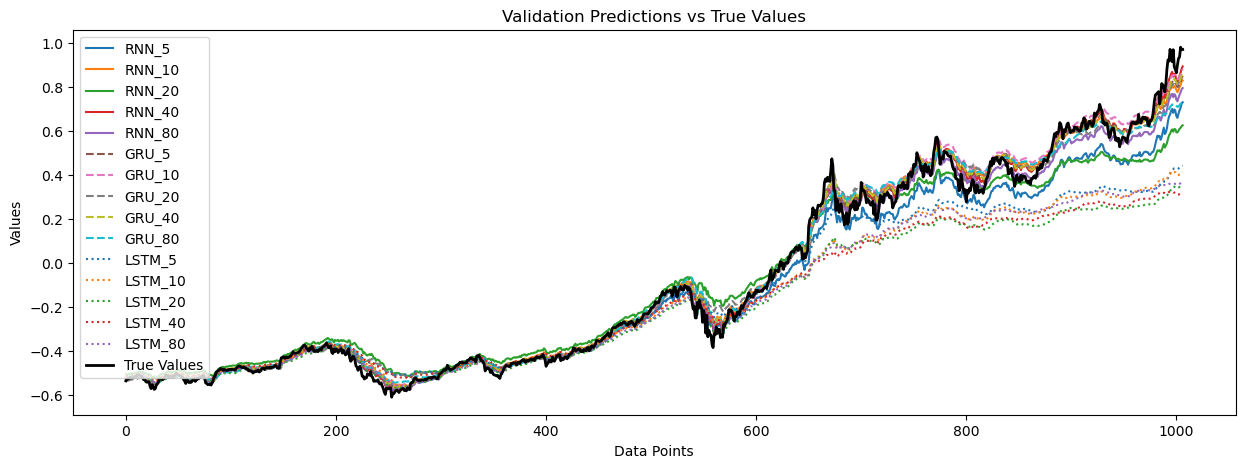

In [22]:
col_names = ["RNN_5", "RNN_10", "RNN_20", "RNN_40", "RNN_80", "GRU_5", "GRU_10", "GRU_20", "GRU_40", "GRU_80", "LSTM_5", "LSTM_10", "LSTM_20", "LSTM_40", "LSTM_80"]

y_val_predictions = pd.DataFrame()

# creating DF of predictions
for i, col_name in enumerate(col_names):
    y_val_predictions[col_name] = y_preds_val[i].ravel()

plt.figure(figsize=(15, 5))

# giving unique line styles to the different model types
line_styles = {'RNN': '-', 'GRU': '--', 'LSTM': ':'}

# Plot each model's predictions with different line styles
for col_name in col_names:
    if 'RNN' in col_name:
        line_style = line_styles['RNN']
    elif 'GRU' in col_name:
        line_style = line_styles['GRU']
    elif 'LSTM' in col_name:
        line_style = line_styles['LSTM']
    else:
        line_style = '-'
    plt.plot(y_val_predictions[col_name], linestyle=line_style, label=col_name)

y_val_true = true_y[0][0]
plt.plot(y_val_true, label='True Values', color='k', linewidth=2)

plt.title('Validation Predictions vs True Values')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.legend()
plt.show()

In [85]:
class SLP(nn.Module): #single layer perceptron just to get linear model of weigthts
    def __init__(self):
        super(SLP, self).__init__()
        self.fc1 = nn.Linear(15, 1)

    def forward(self, x):
        x = self.fc1(x)
        return x

In [151]:
# for the training dataset for the MLP I have to get change the datasets to make them a uniform size. As the only difference is the beginning data this is solved by gathering from the back -> front
training_data_for_MLP = []
for i in RNN_model_predictions:
    training_data_for_MLP.append(i[0][0][len(i[0][0])-4000:])

for i in GRU_model_predictions:
    training_data_for_MLP.append(i[0][0][len(i[0][0])-4000:])

for i in LSTM_model_predictions:
    training_data_for_MLP.append(i[0][0][len(i[0][0])-4000:])
    
col_names = ["RNN_5", "RNN_10", "RNN_20", "RNN_40", "RNN_80", "GRU_5", "GRU_10", "GRU_20", "GRU_40", "GRU_80", "LSTM_5", "LSTM_10", "LSTM_20", "LSTM_40", "LSTM_80"]

td_MLP = pd.DataFrame()

for i, col_name in enumerate(col_names):
    td_MLP[col_name] = training_data_for_MLP[i].ravel()

y_train_true = true_y[0][2][len(true_y[0][2])-4000:]
y_train_pred_train = torch.tensor(y_train_true, dtype=torch.float32).reshape(-1, 1)
x_train_pred_train = torch.tensor(td_MLP.to_numpy(), dtype=torch.float32)

C:\Users\jono_\AppData\Local\Temp\ipykernel_18400\2750573282.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_pred_train = torch.tensor(y_train_true, dtype=torch.float32).reshape(-1, 1)


In [152]:
val_data_for_MLP = []
for i in RNN_model_predictions:
    val_data_for_MLP.append(i[0][1])

for i in GRU_model_predictions:
    val_data_for_MLP.append(i[0][1])

for i in LSTM_model_predictions:
    val_data_for_MLP.append(i[0][1])
    
col_names = ["RNN_5", "RNN_10", "RNN_20", "RNN_40", "RNN_80", "GRU_5", "GRU_10", "GRU_20", "GRU_40", "GRU_80", "LSTM_5", "LSTM_10", "LSTM_20", "LSTM_40", "LSTM_80"]

val_td_MLP = pd.DataFrame()

for i, col_name in enumerate(col_names):
    val_td_MLP[col_name] = val_data_for_MLP[i].ravel()

y_train_true = true_y[0][0]
y_MLP_Val = torch.tensor(y_train_true, dtype=torch.float32).reshape(-1, 1)
x_MLP_Val = torch.tensor(val_td_MLP.to_numpy(), dtype=torch.float32)

C:\Users\jono_\AppData\Local\Temp\ipykernel_18400\2455962980.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_MLP_Val = torch.tensor(y_train_true, dtype=torch.float32).reshape(-1, 1)


In [145]:
# Instantiate the model
model = MLP()

criterion = nn.MSELoss()# Loss function and optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, verbose=True)

# Training and validation data
inputs = x_train_pred_train
targets = y_train_pred_train
val_inputs = x_MLP_Val
val_targets = y_MLP_Val

# for storing best model and statistics
best_val_loss = float('inf')
best_model_state = copy.deepcopy(model.state_dict())
best_stats = []

# Training and val loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_targets)
        mae = torch.abs(val_targets - val_outputs).mean().item()
        rmse = math.sqrt(val_loss.item())
        
    scheduler.step(val_loss)
    
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = copy.deepcopy(model.state_dict())
        best_stats = [epoch, loss.item(), val_loss.item(), mae, rmse]
        true_values = val_targets.detach().numpy()
        predicted_values = val_outputs.detach().numpy()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Training Loss: {loss.item():.5f}, Val Loss: {val_loss.item():.5f}, Val MAE: {mae:.5f}, Val RMSE: {rmse:.5f}')

Epoch 0, Training Loss: 3.03607, Val Loss: 0.38332, Val MAE: 0.56786, Val RMSE: 0.61913
Epoch 100, Training Loss: 0.00005, Val Loss: 0.00278, Val MAE: 0.04250, Val RMSE: 0.05272
Epoch 200, Training Loss: 0.00005, Val Loss: 0.00272, Val MAE: 0.04192, Val RMSE: 0.05215
Epoch 300, Training Loss: 0.00005, Val Loss: 0.00266, Val MAE: 0.04136, Val RMSE: 0.05161
Epoch 400, Training Loss: 0.00005, Val Loss: 0.00261, Val MAE: 0.04083, Val RMSE: 0.05110
Epoch 500, Training Loss: 0.00005, Val Loss: 0.00256, Val MAE: 0.04032, Val RMSE: 0.05061
Epoch 600, Training Loss: 0.00005, Val Loss: 0.00251, Val MAE: 0.03983, Val RMSE: 0.05014
Epoch 700, Training Loss: 0.00005, Val Loss: 0.00247, Val MAE: 0.03936, Val RMSE: 0.04970
Epoch 800, Training Loss: 0.00005, Val Loss: 0.00243, Val MAE: 0.03892, Val RMSE: 0.04928
Epoch 900, Training Loss: 0.00005, Val Loss: 0.00239, Val MAE: 0.03849, Val RMSE: 0.04888


In [160]:
weights = model.fc1.weight.data
print("Weights of linear model:", weights)

Weights of linear model: tensor([[ 0.1777, -0.0300, -0.0457,  0.3146, -0.0745,  0.0987,  0.3601, -0.0111,
         -0.0424,  0.0514,  0.0868, -0.1269,  0.3723, -0.0985,  0.0637]])


Best Model Stats: Best Epoch: 999, Train Loss: 0.00005, Val Loss: 0.00235, Val MAE: 0.03809, Val RMSE: 0.04850


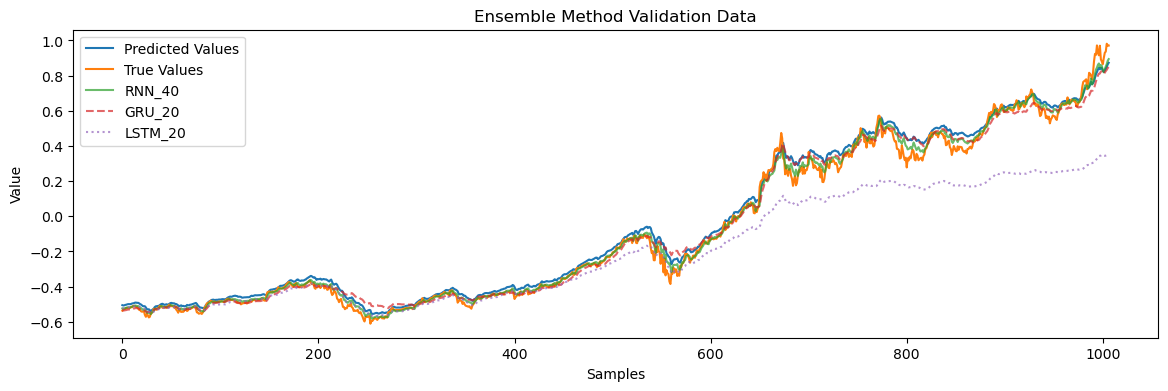

In [157]:
model.load_state_dict(best_model_state)
print(f"Best Model Stats: Best Epoch: {best_stats[0]}, Train Loss: {best_stats[1]:.5f}, Val Loss: {best_stats[2]:.5f}, Val MAE: {best_stats[3]:.5f}, Val RMSE: {best_stats[4]:.5f}")
# Plotting the true values and predicted values
plt.figure(figsize=(14, 4))
plt.plot(predicted_values, label='Predicted Values')
plt.plot(true_values, label='True Values')
plt.plot(val_td_MLP["RNN_40"], label='RNN_40', alpha=0.7, linestyle = '-') # greatest weigth from RNN
plt.plot(val_td_MLP["GRU_20"], label='GRU_20', alpha=0.7, linestyle = '--') # Greatest weight from GRU
plt.plot(val_td_MLP["LSTM_20"], label='LSTM_20', alpha=0.7, linestyle = ':') # greatest weight from LSTM
plt.title('Ensemble Method Validation Data')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.legend()
plt.show()